In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
import nltk
import sys
%matplotlib inline

In [2]:
data_path = "./data/Digital_Music_5.json"
table = pd.read_json(data_path, 'records', lines = True).reset_index(drop = True, inplace = False)
print(table.head())

   overall  vote  verified   reviewTime      reviewerID        asin  \
0        5   3.0      True   06 3, 2013  A2TYZ821XXK2YZ  3426958910   
1        5   NaN      True  10 11, 2014  A3OFSREZADFUDY  3426958910   
2        5   NaN      True  02 11, 2014  A2VAMODP8M77NG  3426958910   
3        4   3.0     False   12 7, 2013   AAKSLZ9IDTEH0  3426958910   
4        5   NaN      True  06 12, 2016  A3OH43OZJLKI09  5557706259   

                      style       reviewerName  \
0  {'Format:': ' Audio CD'}            Garrett   
1  {'Format:': ' Audio CD'}                 Ad   
2  {'Format:': ' Audio CD'}             JTGabq   
3  {'Format:': ' Audio CD'}  john F&#039;n doe   
4  {'Format:': ' Audio CD'}  melinda a goodman   

                                          reviewText  \
0  This is awesome to listen to, A must-have for ...   
1                                               bien   
2  It was great to hear the old stuff again and I...   
3  well best of's are a bit poison normally but 

In [3]:
table.shape

(169781, 12)

In [4]:
table.describe()['overall'].T

count    169781.000000
mean          4.700019
std           0.713420
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [5]:
print('Number of missing values across columns: \n',table.isnull().sum())

Number of missing values across columns: 
 overall                0
vote              162170
verified               0
reviewTime             0
reviewerID             0
asin                   0
style              11792
reviewerName           5
reviewText           158
summary               36
unixReviewTime         0
image             169599
dtype: int64


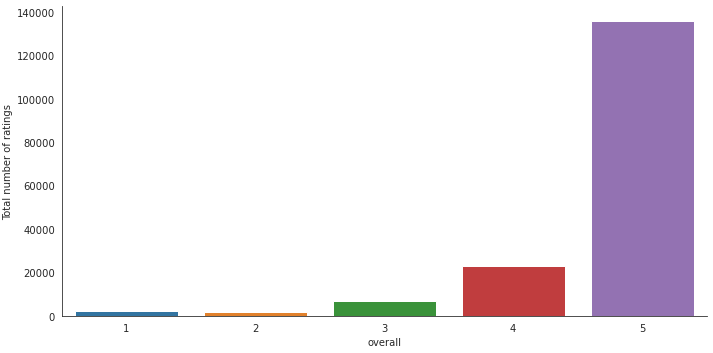

In [6]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("overall", data=table, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [7]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",table.shape[0])
print("Total No of Users   :", len(np.unique(table.reviewerID)))
print("Total No of products  :", len(np.unique(table.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 169781
Total No of Users   : 16566
Total No of products  : 11797


In [8]:
table.drop(['vote'], axis=1,inplace=True)
table.drop(['verified'], axis=1,inplace=True)
table.drop(['reviewTime'], axis=1,inplace=True)
table.drop(['reviewerName'], axis=1,inplace=True)
table.drop(['reviewText'], axis=1,inplace=True)
table.drop(['style'], axis=1,inplace=True)
table.drop(['summary'], axis=1,inplace=True)
table.drop(['unixReviewTime'], axis=1,inplace=True)
table.drop(['image'], axis=1,inplace=True)

In [9]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = table.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviewerID
A3W4D8XOGLWUN5    791
A2H3JURQZOHVMB    314
A36EDWL4F3AASU    223
A165P3MOJV3OVZ    219
AVKHYC2D7MD56     214
Name: overall, dtype: int64

In [10]:
no_of_rated_products_per_user.describe()

count    16566.000000
mean        10.248763
std         12.376589
min          1.000000
25%          5.000000
50%          7.000000
75%         11.000000
max        791.000000
Name: overall, dtype: float64

In [11]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

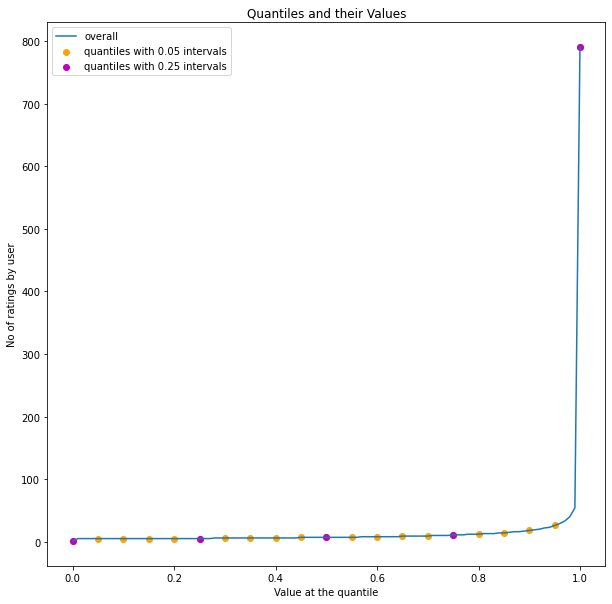

In [12]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [13]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 199



In [14]:
##Popularity Based Recommendation

#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=table.groupby("asin").filter(lambda x:x['overall'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-100.0, 0, ''),
 Text(0.0, 0, ''),
 Text(100.0, 0, ''),
 Text(200.0, 0, ''),
 Text(300.0, 0, ''),
 Text(400.0, 0, ''),
 Text(500.0, 0, '')]

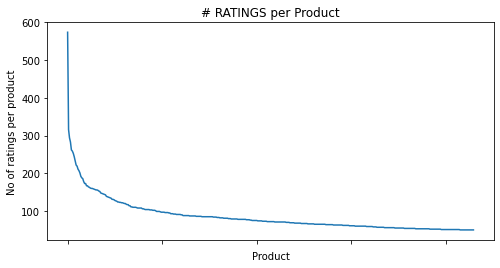

In [15]:
no_of_ratings_per_product = new_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [16]:
#Average rating of the product 

new_df.groupby('asin')['overall'].mean().head()

asin
7799420340    4.784615
9714721180    4.829268
B000JF21D0    4.491525
B000S51XMQ    4.870588
B000T006RI    4.887324
Name: overall, dtype: float64

In [17]:
new_df.groupby('asin')['overall'].mean().sort_values(ascending=False).head()

asin
B000VZYYWY    4.966667
B00136PTYW    4.962963
B00136LMJ8    4.962963
B01DOO46BM    4.962500
B00NJT3GKK    4.962264
Name: overall, dtype: float64

In [18]:
#Total no of rating for product

new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B00CZF8B68    574
B00BWGHIHY    316
B00136J7ZE    294
B00EH49FRE    283
B00136NUG6    262
Name: overall, dtype: int64

In [19]:
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['overall'].mean())

In [20]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())

In [21]:
ratings_mean_count.head()

,overall,rating_counts
asin,,
7799420340,4.784615,65
9714721180,4.829268,82
B000JF21D0,4.491525,59
B000S51XMQ,4.870588,85
B000T006RI,4.887324,71


In [22]:
ratings_mean_count['rating_counts'].max()

574

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

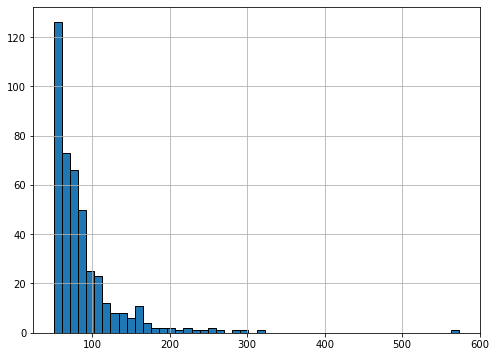

In [23]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

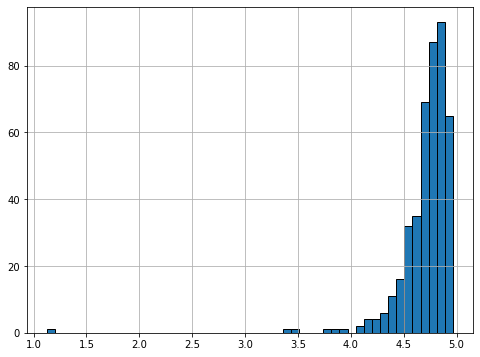

In [24]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['overall'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

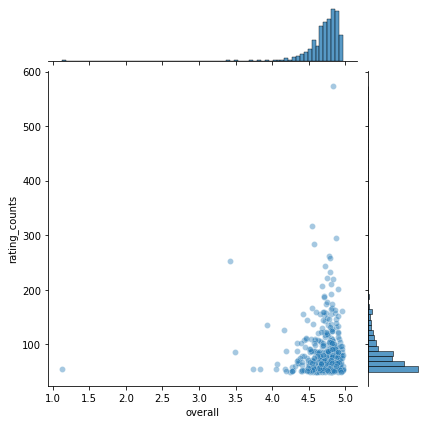

In [25]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='overall', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='asin'>

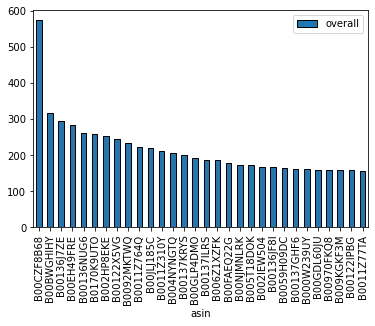

In [26]:
popular_products = pd.DataFrame(new_df.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [27]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [28]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
cols = new_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = new_df[cols] 
# df = df._convert(numeric=True)
print(df)
# print(df.dtypes)
# df['asin']=df['asin'].astype(np.float64)
# print(df.dtypes)

data = Dataset.load_from_df(df,reader)

            reviewerID        asin  overall
23       A9Q28YTLYREO7  7799420340        5
24      A3W4D8XOGLWUN5  7799420340        4
25      A1KCA1O8SPOE8P  7799420340        4
26      A1RY96KKGQ84EE  7799420340        5
27      A3HO0XCG4KZ16R  7799420340        5
...                ...         ...      ...
169734  A2VDTD7VN80C3I  B01H5ZYNM8        5
169735  A38ZDXX8YKKYZC  B01H5ZYNM8        5
169736  A1PH0SIPRL5J5Z  B01H5ZYNM8        5
169737   AJ9INS42ECLQV  B01H5ZYNM8        3
169738  A2MHW0LHWRMY12  B01H5ZYNM8        5

[37135 rows x 3 columns]


In [29]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.2,random_state=0)

In [30]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [31]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [32]:
test_pred

[Prediction(uid='A3CJKFS9JDR2CN', iid='B0011Z74IE', r_ui=5.0, est=5, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A202XXHFRZ5ZVX', iid='B0011Z310Y', r_ui=5.0, est=4.989231447347447, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A3R33KMESG0XGQ', iid='B00136NEAI', r_ui=5.0, est=4.712972936582739, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A20910KKL7O37L', iid='B00BWGHIHY', r_ui=1.0, est=2.007691342443765, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A39U8YINLJFQS3', iid='B0011Z0YQI', r_ui=5.0, est=4.511111111111111, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3D9EXY6AW61TX', iid='B00137IJUM', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AZ741XAKITJXJ', iid='B001NSP4TK', r_ui=5.0, est=5, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A39HK7B1INNEC0', iid='B007JOM5XA', r_ui=5.0, est=5, de

In [33]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.5273


0.5272798277480051

In [35]:
#Model-based collaborative filtering system

ratings_matrix = new_df.pivot_table(values='overall', index='reviewerID', columns='asin', fill_value=0)
ratings_matrix.head()

asin,7799420340,9714721180,B000JF21D0,B000S51XMQ,B000T006RI,B000T1EJ0W,B000TGGTIC,B000V616DS,B000V66URU,B000V66UV6,...,B015Y73TEW,B0161BPHKY,B0170K9UTO,B017TJY2QC,B01929H4VM,B01D41ASOE,B01DOO46BM,B01E7RWTYG,B01F49DZEO,B01H5ZYNM8
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0072041HVZ3465DXUOR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0081575F2F9XQSSIYA3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1006TXWG76H0N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A101N4D8PRU6N5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A101PYPZ8ASKCV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
ratings_matrix.shape

(11521, 430)

In [37]:
X = ratings_matrix.T
X.head()

reviewerID,A0072041HVZ3465DXUOR,A0081575F2F9XQSSIYA3,A1006TXWG76H0N,A101N4D8PRU6N5,A101PYPZ8ASKCV,A101RMTZ93J1KH,A102H31T5V0LLN,A102H3QWRBVJ8E,A103DHU1X6VC9T,A103U341AE3HO4,...,AZVNV38G3FHUJ,AZWGNYTKSK9JS,AZWULMAOSR7IR,AZX4W3CS3CB23,AZX7GXLU4FLAI,AZXWUZ9PPSOTL,AZY0M1ANDSEPL,AZYOVGJLQ03ML,AZYPOLLSDVG4K,AZZHILYMITLGM
asin,,,,,,,,,,,,,,,,,,,,,
7799420340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9714721180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000JF21D0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000S51XMQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000T006RI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X1 = X

In [39]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(430, 10)

In [40]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(430, 430)

In [41]:
X.index[429]

'B01H5ZYNM8'

In [42]:
i = "B01H5ZYNM8"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

429

In [43]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(430,)

In [44]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['7799420340',
 'B000T1EJ0W',
 'B000V66URU',
 'B000V66UV6',
 'B000V68LJ0',
 'B000VWKVSI',
 'B000VZJS20',
 'B000VZV9KY',
 'B000VZXDO4',
 'B000W0112Y',
 'B000W02O2K',
 'B000W0633G',
 'B000W18HWU',
 'B000W1MCQW',
 'B000W23IE6',
 'B000WGMYI8',
 'B000WLOKKS',
 'B000WLOMUQ',
 'B000WOWR00',
 'B000WZWW7M',
 'B000X6TUGQ',
 'B000YKEMZ0',
 'B000Z1GR9C',
 'B000ZMUV2K']